In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from numba import njit, jit, prange
sns.set_style("whitegrid")

In [2]:
a = 3
b = 2
alpha = a/b

S = 100

r_init = S*1 #int(S*0.35)
s_init = S*1 #int(S*0.5)
c_init = S*0 #int(S*0.5)

In [3]:
#fit_parameters = np.load(r'C:\Users\Rohit Vasav\Downloads\params_f_range.npz')
#k_off, k_u, k_b, j_off, J_on_hat, g_off = fit_parameters['params'][0,0]

## Parameters obtained from experimental data
k_off, k_u, k_b, j_off, J_on_hat, g_off = [3.9018766517549692, 1.9799379861044861, 6.615504603306438, 
                                           3.481669158554892, 3.016688368288114, 5.910017828840013]

G_on = J_on_hat/(1+j_off/g_off)
J_on = J_on_hat - G_on

K_on = k_off/(1+(k_b/k_u)*J_on_hat/(j_off+g_off)) - G_on + g_off*J_on_hat/(j_off+g_off)

## Theoretical steady state values
r_star = J_on_hat / (j_off + g_off)
s_star = (K_on + G_on -g_off*r_star) / k_off
c_star = k_b/k_u * r_star * s_star

## Scaling the parameters with S
J_on *= S
G_on *= S
k_b /= S
K_on *= S

In [4]:
T_end = 14
dt = 0.01

time_arr = np.arange(0,T_end,dt)
time_steps = len(time_arr)

num_trials = 1000

In [5]:
rand_num = 314 #np.random.randint(1,1717)
np.random.seed(rand_num)
rand_num

314

In [6]:
D = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])*2*S*100
fluxes = np.array([J_on, G_on, k_u*c_star*S/b, g_off*r_star*S, j_off*r_star*S, k_b*(r_star*s_star*S**2)/b, K_on, k_off*s_star*S])

In [7]:
@njit(parallel=True)
def langevin_process(r_init, s_init, c_init, fluxes, num_trials, time_steps):
    
    r = np.zeros((num_trials,time_steps),dtype=np.float64)
    s = np.zeros((num_trials,time_steps),dtype=np.float64)
    c = np.zeros((num_trials,time_steps),dtype=np.float64)
    
    r[:,0], s[:,0], c[:,0] = r_init, s_init, c_init
    
    for trial in prange(num_trials):
        
        for t in prange(1,time_steps):

            rates = np.array([J_on, G_on, k_u*c[trial,t-1]/b, g_off*r[trial,t-1], j_off*r[trial,t-1], 
                              k_b*r[trial,t-1]*s[trial,t-1]/b, K_on, k_off*s[trial,t-1]],dtype = np.float64)
            
            xi = np.array([np.random.normal(0,np.sqrt(fluxes[i]/dt)) for i in range(8)],dtype=np.float64)

            r[trial,t] = r[trial,t-1] + dt*(  (alpha*rates[2] + xi[2]) 
                                - (alpha*rates[5] + xi[5])
                                - (rates[4] + xi[4])
                                - (rates[3] + xi[3])
                                + (rates[0] + xi[0])
                                + (rates[1] + xi[1]) )

            s[trial,t] = s[trial,t-1] + dt*(  (rates[2] + xi[2]) 
                                - (rates[5] + xi[5])
                                - (rates[7] + xi[7])
                                - (rates[3] + xi[3])
                                + (rates[6] + xi[6])
                                + (rates[1] + xi[1]) )

            c[trial,t] = c[trial,t-1] + dt*( -(rates[2] + xi[2]) + (rates[5] + xi[5]) )
            
    return r,s,c

In [8]:
r, s, c = langevin_process(r_init, s_init, c_init, fluxes, num_trials, time_steps)

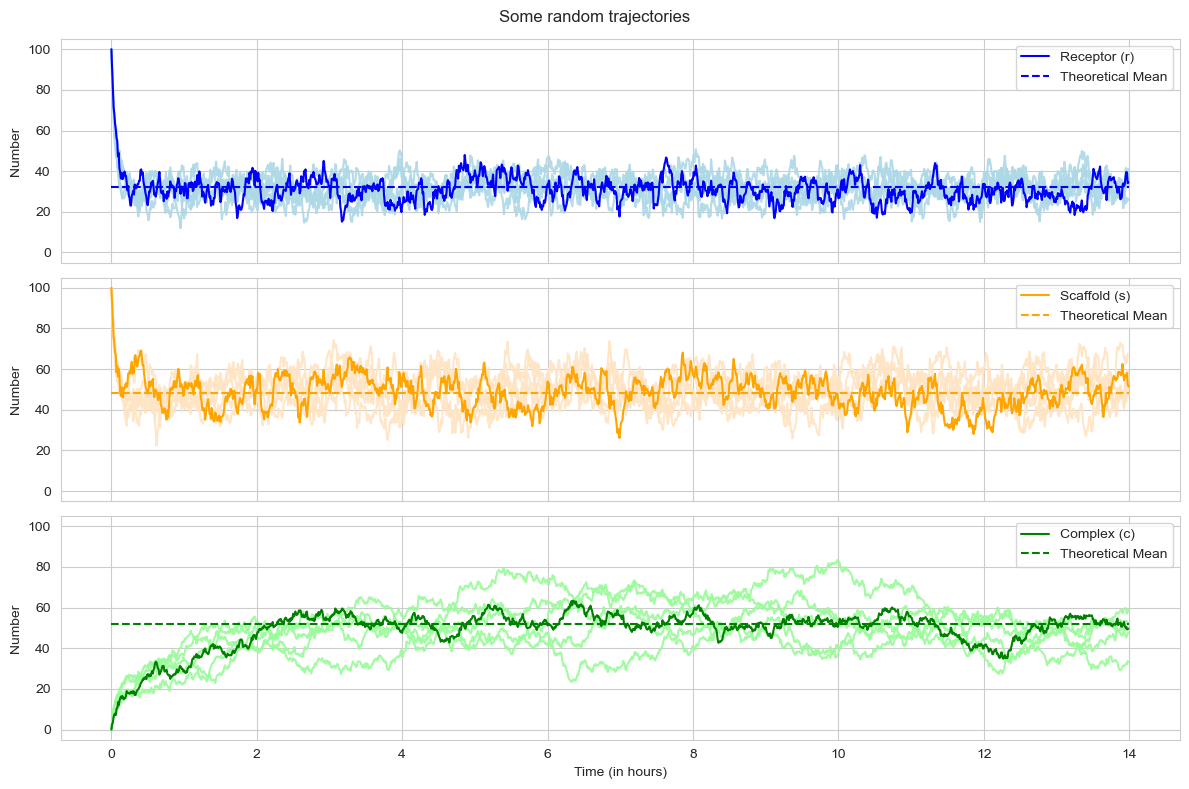

In [13]:
fig, axs = plt.subplots(3, figsize=(12,8), sharex=True, sharey=True)

for i in np.random.randint(1,num_trials,5):
    axs[0].plot(time_arr,r[i,:],color='lightblue',alpha=0.9)
axs[0].plot(time_arr,r[0,:],color='blue',label = "Receptor (r)")
axs[0].hlines(r_star*S,xmin=0,xmax=T_end,color='blue',ls='--',lw=1.5,label="Theoretical Mean")
axs[0].set_ylabel("Number")
axs[0].legend(loc='upper right')

for i in np.random.randint(1,num_trials,5):
    axs[1].plot(time_arr,s[i,:],color='bisque',alpha=0.9)
axs[1].plot(time_arr,s[0,:],color='orange',label="Scaffold (s)")
axs[1].hlines(s_star*S,xmin=0,xmax=T_end,color='orange',ls='--',lw=1.5,label="Theoretical Mean")
axs[1].set_ylabel("Number")
axs[1].legend(loc='upper right')

for i in np.random.randint(1,num_trials,5):
    axs[2].plot(time_arr,c[i,:],color='palegreen',alpha=0.9)
axs[2].plot(time_arr,c[0,:],color='green',label="Complex (c)")
axs[2].hlines(c_star*S,xmin=0,xmax=T_end,color='green',ls='--',lw=1.5,label="Theoretical Mean")
axs[2].set_ylabel("Number")
axs[2].set_xlabel("Time (in hours)")
axs[2].legend(loc='upper right')

fig.suptitle('Some random trajectories')
fig.tight_layout()
plt.show()

In [9]:
mean_r = np.mean(r,axis=0)
mean_s = np.mean(s,axis=0)
mean_c = np.mean(c,axis=0)

std_r = np.std(r,axis=0)
std_s = np.std(s,axis=0)
std_c = np.std(c,axis=0)

In [15]:
r_stat = r[:,time_steps//2:].flatten()
s_stat = s[:,time_steps//2:].flatten()
c_stat = c[:,time_steps//2:].flatten()

num_stat = r_stat.shape[0]

mu_r, sigma_r = np.mean(r_stat), np.std(r_stat)
mu_s, sigma_s = np.mean(s_stat), np.std(s_stat)
mu_c, sigma_c = np.mean(c_stat), np.std(c_stat)

print(num_stat)
print(mu_r, r_star*S, abs(mu_r/S-r_star)/r_star * 100,"% error")
print(mu_s, s_star*S, abs(mu_s/S-s_star)/s_star * 100,"% error")
print(mu_c, c_star*S, abs(mu_c/S-c_star)/c_star * 100,"% error")
print((mu_s + mu_c)/S, abs((mu_s + mu_c)/S - 1) * 100,"% error")

print(sigma_r,sigma_s,sigma_c)

700000
32.11276513567821 32.120835930083445 0.025126352324070515 % error
48.074571554569296 48.23360340267108 0.32971172975431223 % error
52.07963937133541 51.766396597328914 0.6051083223796528 % error
1.001542109259047 0.15421092590470753 % error
5.5578984251231205 8.667676903096831 7.915145059616802


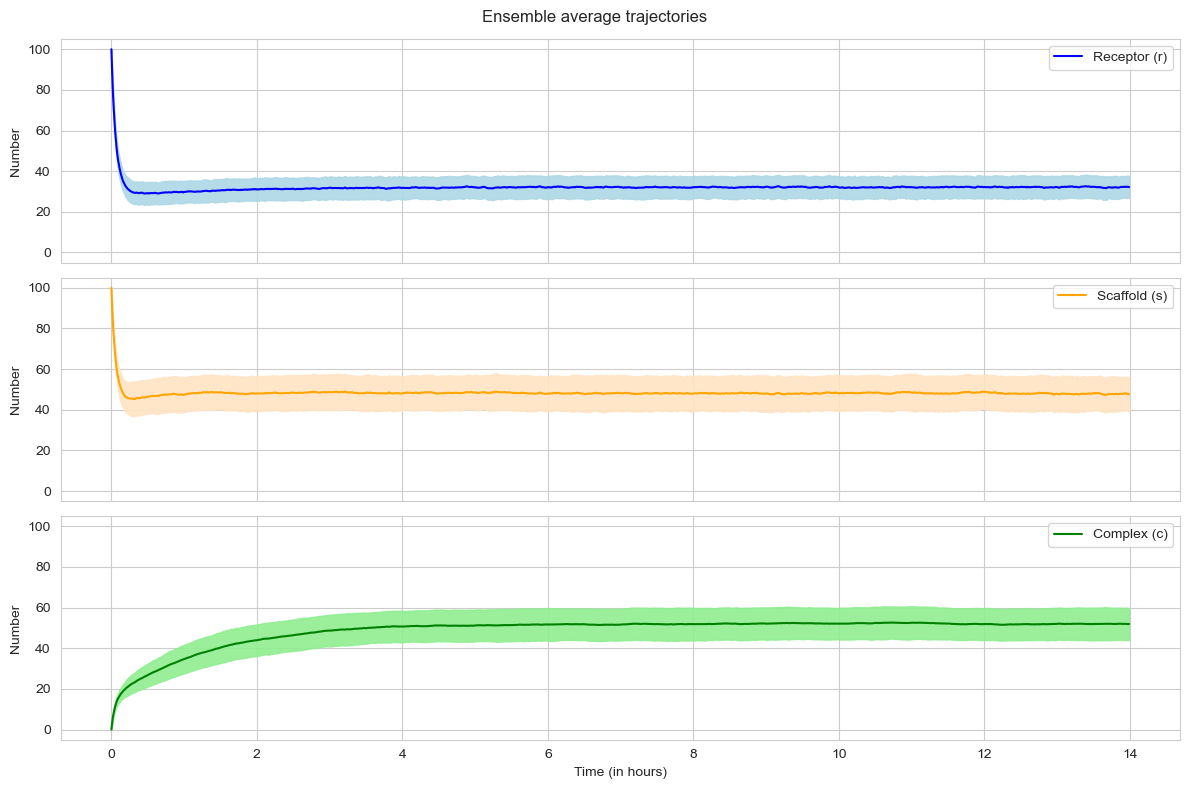

In [10]:
fig, axs = plt.subplots(3, figsize=(12,8), sharex=True, sharey=True)

axs[0].fill_between(time_arr, mean_r-std_r, mean_r+std_r, color='lightblue',alpha=0.9)
axs[0].plot(time_arr,mean_r,color='blue',label = "Receptor (r)")
axs[0].set_ylabel("Number")
axs[0].legend()

axs[1].fill_between(time_arr, mean_s-std_s, mean_s+std_s, color='bisque',alpha=0.9)
axs[1].plot(time_arr,mean_s,color='orange',label="Scaffold (s)")
axs[1].set_ylabel("Number")
axs[1].legend()

axs[2].fill_between(time_arr, mean_c-std_c, mean_c+std_c, color='lightgreen',alpha=0.9)
axs[2].plot(time_arr,mean_c,color='green',label="Complex (c)")
axs[2].set_ylabel("Number")
axs[2].set_xlabel("Time (in hours)")
axs[2].legend(loc='upper right')

fig.suptitle('Ensemble average trajectories')
fig.tight_layout()
plt.show()